# From RAG to Deploy: Building and Deploying a Retrieval Augmented Generation (RAG) App

https://python.langchain.com/v0.2/docs/tutorials/rag/


In [62]:
from dotenv import load_dotenv
load_dotenv()

True

Una de las aplicaciones más interesantes que nos permiten los LLMs son las preguntas y respuestas (Q&A) en formato chatbot. Son aplicaciones que pueden responder preguntas acerca de información específica. Estas aplicaciones usan una técnica conocida como RAG, o Retrieval Augmented Generation.

En este notebook vamos a construir una aplicación Q&A sobre una fuente de datos y veremos como LangSmith puede ayudarnos a como monitorizar y entender nuestra aplicación. LangSmith es una solución interesante cuando la aplicación crece en complejidad.

En el ejemplo vamos a focalizarnos en construir una Q&A de datos no estructurados. Si te interesa aprender cómo hacer un RAG sobre datos estructurados como SQL, puedes ver este notebook **aquí**.

Básicamente, una aplicación RAG tiene dos componentes principales:

- INDEXING. Un pipline para ingerir los datos de la fuente e indexarlos. Suele ocurrir offline.
- RETRIEVAL y GENERATION. La RAG chain utilizará la query del usuario en tiempo de ejecución y recuperará la información relevante del índex, para luego pasarla al LLM y generar la respuesta.

La fase de INDEXING tiene estas etapas:

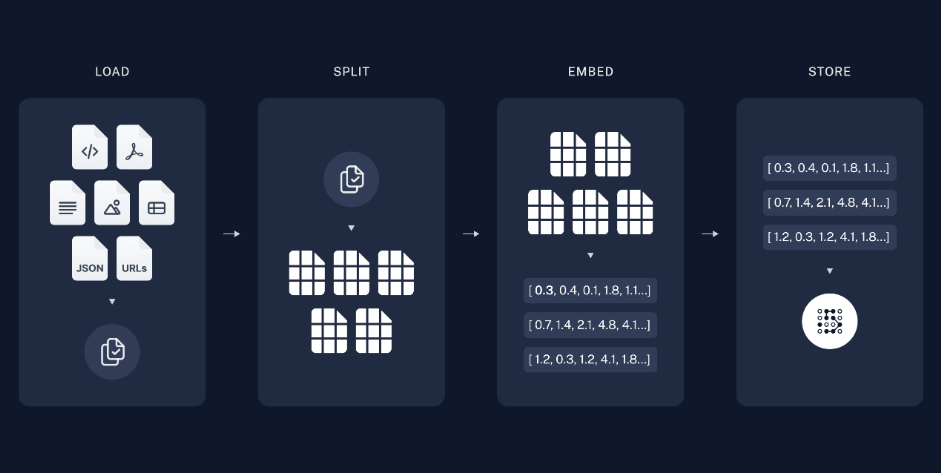

- LOAD. Cargamos los datos, podemos utilizar los DocumentLoaders que nos ofrece LangChain. Estas clases cargan objetos Documents, similares a cómo los trata LlamaIndex y que te explicaba **aquí** o ver la definición oficial de la clase aquí: https://api.python.langchain.com/en/latest/documents/langchain_core.documents.base.Document.html Estos frameworks tienen cientos de integraciones con diferentes fuentes de datos para cargar la información: Slack, Notion, Google Drive, etc.

https://python.langchain.com/v0.2/docs/concepts/#document-loaders

https://python.langchain.com/v0.2/docs/how_to/#document-loaders

En el caso de documentos PDF:

https://python.langchain.com/v0.2/docs/how_to/document_loader_pdf/

Por ejemplo, usando PyPDF:

In [63]:
%pip install pypdf

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from langchain_community.document_loaders import PyPDFLoader

file_path = ("<tu-ruta-al-archivo>")

loader = PyPDFLoader(file_path)
pages = loader.load_and_split()

pages

[Document(page_content='World Development 174 (2024) 106437\nAvailable online 31 October 2023\n0305-750X/© 2023 The Authors. Published by Elsevier Ltd. This is an open access article under the CC BY-NC-ND license ( http://creativecommons.org/licenses/by-\nnc-nd/4.0/ ).\nContents lists available at ScienceDirect\nWorld Development\njournal homepage: www.elsevier.com/locate/worlddev\nImmigration, labor markets and discrimination: Evidence from the\nVenezuelan Exodus in Perú\nAndre Groegera,∗, Gianmarco León-Ciliottab, Steven Stillmanc\naUniversitat Autonoma de Barcelona (UAB) and Barcelona School of Economics (BSE), Spain\nbUniversitat Pompeu Fabra (UPF), Barcelona School of Economics (BSE), and Institute of Political Economy and Governance (IPEG), Spain\ncFree University of Bozen-Bolzano, IZA, and CESifo, Italy, Germany and Germany\nA R T I C L E I N F O\nDataset link: Replication Data for: "Immigration\n, Labor Markets and Discrimination: Evidence f\nrom the Venezuelan Exodus in Peru" 

Para serialñizar y mostrar el objeto Document como un JSON vamos a utilizar la biblioteca json de Python:

In [65]:
import json
import logging
from langchain_community.document_loaders import PyPDFLoader

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class Document:
    def __init__(self, page_content, metadata):
        self.page_content = page_content
        self.metadata = metadata

    def to_dict(self):
        return {
            'page_content': self.page_content,
            'metadata': self.metadata
        }

def serialize_document(document):
    """
    Serializa un objeto Document en formato JSON.

    Args:
    document (Document): El objeto Document a serializar.

    Returns:
    str: El JSON del objeto Document.
    """
    try:
        document_dict = document.to_dict()
        document_json = json.dumps(document_dict, indent=4, ensure_ascii=False)
        logger.info("Document serialized successfully")
        return document_json
    except Exception as e:
        logger.error(f"Error serializing document: {e}")
        raise

# Crear el objeto Document con la primera página (el primero objeto de la lista)
first_page_content = pages[0].page_content
first_page_metadata = pages[0].metadata

document = Document(first_page_content, first_page_metadata)

# Serializar el objeto Document
document_json = serialize_document(document)
print(document_json)


INFO:__main__:Document serialized successfully


{
    "page_content": "World Development 174 (2024) 106437\nAvailable online 31 October 2023\n0305-750X/© 2023 The Authors. Published by Elsevier Ltd. This is an open access article under the CC BY-NC-ND license ( http://creativecommons.org/licenses/by-\nnc-nd/4.0/ ).\nContents lists available at ScienceDirect\nWorld Development\njournal homepage: www.elsevier.com/locate/worlddev\nImmigration, labor markets and discrimination: Evidence from the\nVenezuelan Exodus in Perú\nAndre Groegera,∗, Gianmarco León-Ciliottab, Steven Stillmanc\naUniversitat Autonoma de Barcelona (UAB) and Barcelona School of Economics (BSE), Spain\nbUniversitat Pompeu Fabra (UPF), Barcelona School of Economics (BSE), and Institute of Political Economy and Governance (IPEG), Spain\ncFree University of Bozen-Bolzano, IZA, and CESifo, Italy, Germany and Germany\nA R T I C L E I N F O\nDataset link: Replication Data for: \"Immigration\n, Labor Markets and Discrimination: Evidence f\nrom the Venezuelan Exodus in Peru\"

Otras opciones, por ejemplo:

In [66]:
# Using PyMuPDF para extraer más metadatos del PDF

from langchain_community.document_loaders import PyMuPDFLoader

loader = PyMuPDFLoader("<tu-ruta-al-archivo>")
data = loader.load()

# Crear el objeto Document con la primera página (el primero objeto de la lista)
first_page_content = data[0].page_content
first_page_metadata = data[0].metadata

document = Document(first_page_content, first_page_metadata)

# Serializar el objeto Document
document_json = serialize_document(document)
print(document_json)

INFO:__main__:Document serialized successfully


{
    "page_content": "World Development 174 (2024) 106437\nAvailable online 31 October 2023\n0305-750X/© 2023 The Authors. Published by Elsevier Ltd. This is an open access article under the CC BY-NC-ND license (http://creativecommons.org/licenses/by-\nnc-nd/4.0/).\nContents lists available at ScienceDirect\nWorld Development\njournal homepage: www.elsevier.com/locate/worlddev\nImmigration, labor markets and discrimination: Evidence from the\nVenezuelan Exodus in Perú\nAndre Groeger a,∗, Gianmarco León-Ciliotta b, Steven Stillman c\na Universitat Autonoma de Barcelona (UAB) and Barcelona School of Economics (BSE), Spain\nb Universitat Pompeu Fabra (UPF), Barcelona School of Economics (BSE), and Institute of Political Economy and Governance (IPEG), Spain\nc Free University of Bozen-Bolzano, IZA, and CESifo, Italy, Germany and Germany\nA R T I C L E\nI N F O\nDataset link: Replication Data for: \"Immigration\n, Labor Markets and Discrimination: Evidence f\nrom the Venezuelan Exodus in P

In [67]:
# O cargar de un directorio todos los archivos PDF que hayan

from langchain_community.document_loaders import PyPDFDirectoryLoader

directory_path = "<tu-ruta-al-directorio>"
loader = PyPDFDirectoryLoader(directory_path)


docs = loader.load()
docs

[Document(page_content='1\nVol.:(0123456789) Scientific Reports  |         (2024) 14:2107  | https://doi.org/10.1038/s41598-024-52417-5\nwww.nature.com/scientificreportsBilingual disadvantages are \nsystematically compensated \nby bilingual advantages \nacross tasks and populations\nVittoria Dentella 1*, Camilla Masullo 1 & Evelina Leivada 2,3\nBilingualism is linked to both enhanced and hampered performance in various cognitive measures, \nyet the extent to which these bilingual advantages and disadvantages co-occur is unclear. To address \nthis gap, we perform a systematic review and two quantitative analyses. First, we analyze results \nfrom 39 studies, obtained through the PRISMA method. Less than 50% of the studies that show up as \nresults for the term “bilingual disadvantage” report exclusively a disadvantage, that shows bilinguals \nperforming worse than monolinguals in a task. A Bayesian analysis reveals robust evidence for \nbilingual effects, but no evidence for differences 

Estas clases suelen devolver un objeto Document por cada página del documento original.

- SPLIT. La siguiente etapa es dividir los documentos de gran tamaño en trozos mñas pequeños o "chunks". Básicamente, cuando tienes cargdos los documentos, tendrás que transformalos de la manera que mejor encaje con tu caso de uso (por ejemplo, evitar que sobrepasen la ventana de contexto de los modelos), aunque no es trivial, ya que hay que mantenear la relevancia o la coherencia entre los diferentes trozos.

https://python.langchain.com/v0.2/docs/concepts/#text-splitters

Una aproximación para texto genérica sería parametrizar por una lista de caracteres (\n, "", etc.). Esta clase intenta mantener los párrafos (las frases y las palabras) juntas lo mejor posible para no perder el significado semántico del texto.

https://python.langchain.com/v0.2/docs/how_to/recursive_text_splitter/

In [68]:
%pip install -qU langchain-text-splitters

Note: you may need to restart the kernel to use updated packages.


In [69]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load example document
with open("<tu-ruta-al-archivo>") as f:
    example_document = f.read()

text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=100,
    chunk_overlap=20,
    length_function=len,
    is_separator_regex=False,
)
texts = text_splitter.create_documents([example_document])

print(texts[0])
print(texts[1])

page_content='18 Vol.1234567890 Scientific Reports 2024 142107 httpsdoi.org10.1038s41598024524175'
page_content='www.nature.comscientificreports 58. Pelham, S. D. Abrams, L. Cognitive advantages and disadvantages'


- chunk_size: The maximum size of a chunk, where size is determined by the length_function.
- chunk_overlap: Target overlap between chunks. Overlapping chunks helps to mitigate loss of information when context is divided between chunks.
- length_function: Function determining the chunk size.
- is_separator_regex: Whether the separator list (defaulting to ["\n\n", "\n", " ", ""]) should be interpreted as regex.

- STORE. Necesitamos un lugar donde almacenar el índice y las divisiones para luego poder buscar sobre ellos. Para ello utilizamos las VectorStore y los modelos de Embeddings.

https://python.langchain.com/v0.2/docs/concepts/#vectorstores

Las VectorStore son la manera más frecuente de almacenar y buscar sobre información no estructurada. El proceso pasa por crear embeddings de la información y almacenarlos en una base de datos vectorizada. Luego, en tiempo de ejecución, crear un embedding de la query del usuario y recuperar los embeddings que son más similares a esa query. Muchas VectorStore permiten también almacenar metadata, cosa que permite filtrar por esa metadata antes de hacer una búsqueda por similitud, ofreciendo más control de la información que se recupera.

- RETRIEVAL y GENERATION. Dado un input de un usuario, se recupera información relevante de una VectorStore mediente un Retriever. El retriever no necesariamente almacena documentos, solo los devuelve (o retrieve)

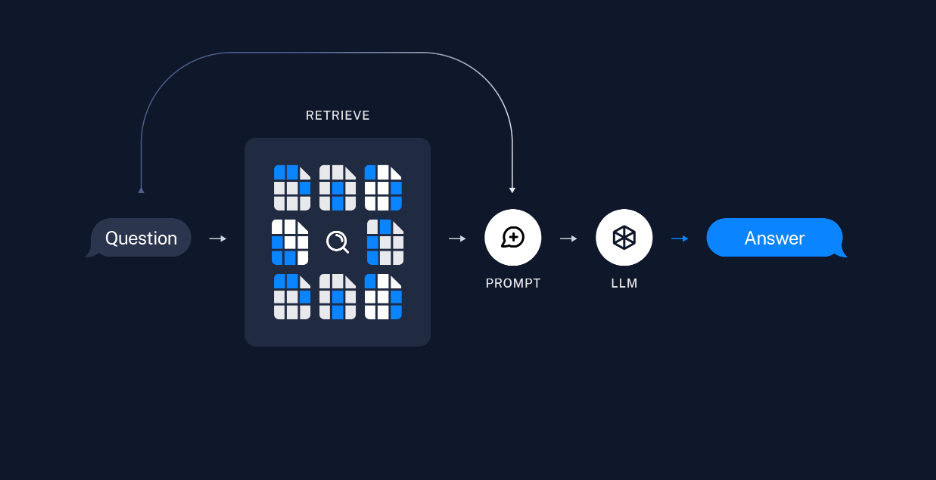

https://python.langchain.com/v0.2/docs/how_to/vectorstore_retriever/

Un vector store retriever es un retriever que usa una vector store para recuperar información. Es como un envoltorio en torno a la clase vector store que le da una interfaz para usar métodos de búsqueda como búsqueda por similitud, MMR, etc.

In [70]:
# %pip install langchain-openai

In [71]:
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import CharacterTextSplitter

loader = TextLoader("<tu-ruta-al-archivo>")

documents = loader.load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(documents)

# Utilizamos el modelo de embeddings de OpenAI
embeddings = OpenAIEmbeddings()
# Utilizamos FAISS (Facebook AI Similarity Search): https://ai.meta.com/tools/faiss/
vectorstore = FAISS.from_documents(texts, embeddings)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [72]:
retriever = vectorstore.as_retriever()
retriever

VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x000002B8F7274610>)

In [73]:
docs = retriever.invoke("what are the Bilingual disadvantages that paper talks about?")
docs

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


[Document(page_content='18 Vol.1234567890 Scientific Reports 2024 142107 httpsdoi.org10.1038s41598024524175 www.nature.comscientificreports 58. Pelham, S. D. Abrams, L. Cognitive advantages and disadvantages in early and late bilinguals. J. Exp. Psychol. 402, 313325 2014. 59. Folke, T., Ouzia, J., Bright, P ., De Martino, B. Filippi, R. A bilingual disadvantage in metacognitive processing. Cognition 150, 119132 2016. 60. Desjardins, J. L., Barraza, E. G. Orozco, J. A. Agerelated changes in speech recognition performance in SpanishEnglish bilin guals first and second languages. JSLHR 627, 25532563 2019. 61. Sadat, J., Martin, C. D., Magnuson, J. S., Alario, F. X. Costa, A. Breaking down the bilingual cost in speech production. Cogn. Sci. 408, 19111940 2016. 62. Lam, B. Sheng, L. Taxonomic development in young bilingual children Task matters, and so does scoring method. Am. J. Speech Lang. Pathol. 293, 11621177 2020. 63. LangeKuettner, C., Markowska, M. Kochhar, R. Deterioration and reco

In [74]:
# O podemos usar Maximum marginal relevance retrieval (MMR)
# MMR intenta reducir la redundancia de resultados y al mismo tiempo mantiene la relevancia de la consulta de los resultados para documentos/frases ya clasificados, etc.

retriever = vectorstore.as_retriever(search_type="mmr")
docs = retriever.invoke("what are the Bilingual disadvantages that paper talks about?")
docs

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


[Document(page_content='18 Vol.1234567890 Scientific Reports 2024 142107 httpsdoi.org10.1038s41598024524175 www.nature.comscientificreports 58. Pelham, S. D. Abrams, L. Cognitive advantages and disadvantages in early and late bilinguals. J. Exp. Psychol. 402, 313325 2014. 59. Folke, T., Ouzia, J., Bright, P ., De Martino, B. Filippi, R. A bilingual disadvantage in metacognitive processing. Cognition 150, 119132 2016. 60. Desjardins, J. L., Barraza, E. G. Orozco, J. A. Agerelated changes in speech recognition performance in SpanishEnglish bilin guals first and second languages. JSLHR 627, 25532563 2019. 61. Sadat, J., Martin, C. D., Magnuson, J. S., Alario, F. X. Costa, A. Breaking down the bilingual cost in speech production. Cogn. Sci. 408, 19111940 2016. 62. Lam, B. Sheng, L. Taxonomic development in young bilingual children Task matters, and so does scoring method. Am. J. Speech Lang. Pathol. 293, 11621177 2020. 63. LangeKuettner, C., Markowska, M. Kochhar, R. Deterioration and reco

In [75]:
# Y podemos controlar el número de chunks relevantes que se recuperan con el parámetro k

retriever = vectorstore.as_retriever(search_kwargs={"k": 1})
docs = retriever.invoke("what are the Bilingual disadvantages that paper talks about?")
len(docs)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


1

Las VectorStore son solo un tipo de retrieval, pero hay muchos más.

Por ejemplo, si extraer la información del documento (metadata) podría llegar a ser más relevante que indexar todo el texto por si mismo puedes utilizar Multi Vector. Esto implica crear múltiples vectores para cada documento, que pueden incluir resúmenes del texto o preguntas hipotéticas.

https://python.langchain.com/v0.2/docs/how_to/multi_vector/


In [76]:
# https://api.python.langchain.com/en/latest/stores/langchain_core.stores.InMemoryByteStore.html
from langchain.storage import InMemoryByteStore

from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import CharacterTextSplitter

loader = TextLoader("<tu-ruta-al-archivo>")

documents = loader.load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
docs = text_splitter.split_documents(documents)

# Utilizamos el modelo de embeddings de OpenAI
embeddings = OpenAIEmbeddings()
# Utilizamos FAISS (Facebook AI Similarity Search): https://ai.meta.com/tools/faiss/
vectorstore = FAISS.from_documents(docs, embeddings)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [77]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever

# The storage layer for the parent documents
store = InMemoryByteStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)

doc_ids = [str(uuid.uuid4()) for _ in docs]
retriever

MultiVectorRetriever(vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x000002B8FB053A90>, byte_store=<langchain_core.stores.InMemoryBaseStore object at 0x000002B8FBFA6290>, docstore=<langchain.storage.encoder_backed.EncoderBackedStore object at 0x000002B8FB02A650>)

In [78]:
# The splitter to use to create smaller chunks
child_text_splitter = RecursiveCharacterTextSplitter(chunk_size=400)

sub_docs = []
for i, doc in enumerate(docs):
    _id = doc_ids[i]
    _sub_docs = child_text_splitter.split_documents([doc])
    for _doc in _sub_docs:
        _doc.metadata[id_key] = _id
    sub_docs.extend(_sub_docs)

sub_docs

# Fíjate que al final del objeto estamos guardamos el identificador del documento en la metadata

[Document(page_content='18 Vol.1234567890 Scientific Reports 2024 142107 httpsdoi.org10.1038s41598024524175 www.nature.comscientificreports 58. Pelham, S. D. Abrams, L. Cognitive advantages and disadvantages in early and late bilinguals. J. Exp. Psychol. 402, 313325 2014. 59. Folke, T., Ouzia, J., Bright, P ., De Martino, B. Filippi, R. A bilingual disadvantage in metacognitive processing. Cognition 150, 119132 2016. 60.', metadata={'source': 'C:\\Users\\Usuario\\Downloads\\codigo-llm\\loading\\data\\Bilingual disadvantages are systematically compensated by bilingual advantages across tasks and populations.txt', 'doc_id': '98900234-b688-4b0e-832e-9a519da09242'}),
 Document(page_content='bilinguals. J. Exp. Psychol. 402, 313325 2014. 59. Folke, T., Ouzia, J., Bright, P ., De Martino, B. Filippi, R. A bilingual disadvantage in metacognitive processing. Cognition 150, 119132 2016. 60. Desjardins, J. L., Barraza, E. G. Orozco, J. A. Agerelated changes in speech recognition performance in S

In [79]:
retriever.vectorstore.add_documents(sub_docs)
retriever.docstore.mset(list(zip(doc_ids, docs)))

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [80]:
# La vector store por si sola recuperará pequeños chunks de información
retriever.vectorstore.similarity_search("inmigración")[0]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Document(page_content='77. Leivada, E., RodriguezOrdonez, I., ParafitaCouto, M. C. Perpinan, S. Bilingualism with minority languages Why searching for unicorn language users does not move us forward. Appl. Psychol. 443, 384399 2023. Author contributions V .D., C.M. and E.L. wrote the main manuscript text. Funding V .D. and C.M. acknowledge funding from the European Unions Horizon 2020 research and innova tion programme', metadata={'source': 'C:\\Users\\Usuario\\Downloads\\codigo-llm\\loading\\data\\Bilingual disadvantages are systematically compensated by bilingual advantages across tasks and populations.txt', 'doc_id': '98900234-b688-4b0e-832e-9a519da09242'})

In [81]:
# Mientras que el retriever devolverá el documento original
len(retriever.invoke("inmigración")[0].page_content)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


5831


https://python.langchain.com/v0.2/docs/concepts/#embedding-models

En el caso de los modelos de Embeddings, lo que hacen es crear una representación vectorial de un trozo de texto. Esto es, un array de números que captura el significado semántico de un texto. Representando el texto de esta manera te permite realizar operaciones matemáticas que te hace poder hacer cosas como buscar otros trozos de texto que tienen un significado similar. 

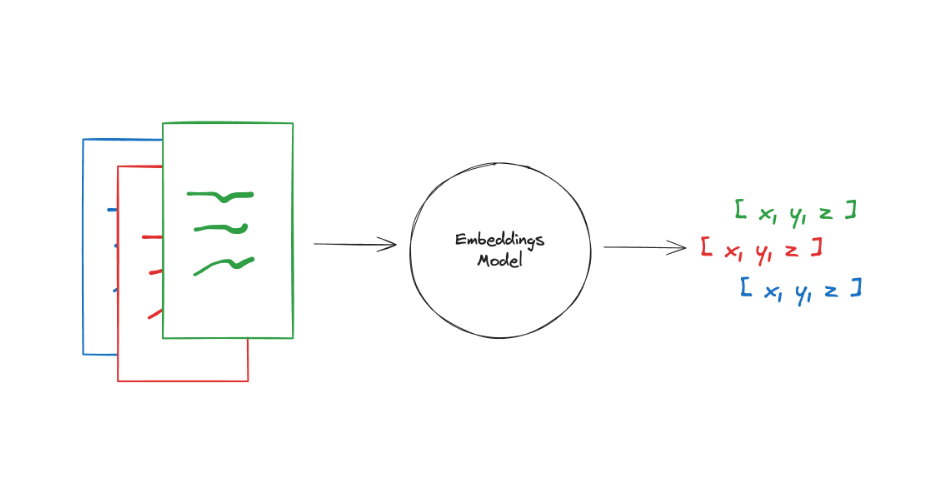

In [82]:
from langchain_openai import OpenAIEmbeddings

embeddings_model = OpenAIEmbeddings()

embeddings = embeddings_model.embed_documents(
    [
        "Hi there!",
        "Oh, hello!",
        "What's your name?",
        "My friends call me World",
        "Hello World!"
    ]
)
len(embeddings), len(embeddings[0])

# El modelo de emebeddings de OpenAI tiene 1536 dimensiones

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


(5, 1536)

In [83]:
embedded_query = embeddings_model.embed_query("What was the name mentioned in the conversation?")
embedded_query[:5]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


[0.005377273540943861,
 -0.0006527779041789472,
 0.038980286568403244,
 -0.002967397216707468,
 -0.008834563195705414]

Si lo juntamos todo:

In [84]:
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import CharacterTextSplitter

loader = TextLoader("<tu-ruta-al-archivo>")

documents = loader.load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(documents)

# Utilizamos el modelo de embeddings de OpenAI
embeddings = OpenAIEmbeddings()
# Utilizamos FAISS (Facebook AI Similarity Search): https://ai.meta.com/tools/faiss/
vectorstore = FAISS.from_documents(texts, embeddings)

# similarity search
query = "what are the Bilingual disadvantages that paper talks about?"
docs = vectorstore.similarity_search(query)
print(docs[0].page_content)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


18 Vol.1234567890 Scientific Reports 2024 142107 httpsdoi.org10.1038s41598024524175 www.nature.comscientificreports 58. Pelham, S. D. Abrams, L. Cognitive advantages and disadvantages in early and late bilinguals. J. Exp. Psychol. 402, 313325 2014. 59. Folke, T., Ouzia, J., Bright, P ., De Martino, B. Filippi, R. A bilingual disadvantage in metacognitive processing. Cognition 150, 119132 2016. 60. Desjardins, J. L., Barraza, E. G. Orozco, J. A. Agerelated changes in speech recognition performance in SpanishEnglish bilin guals first and second languages. JSLHR 627, 25532563 2019. 61. Sadat, J., Martin, C. D., Magnuson, J. S., Alario, F. X. Costa, A. Breaking down the bilingual cost in speech production. Cogn. Sci. 408, 19111940 2016. 62. Lam, B. Sheng, L. Taxonomic development in young bilingual children Task matters, and so does scoring method. Am. J. Speech Lang. Pathol. 293, 11621177 2020. 63. LangeKuettner, C., Markowska, M. Kochhar, R. Deterioration and recovery in verbal recall Re

In [85]:
# similarity search by vector
embedding_vector = OpenAIEmbeddings().embed_query(query)
docs = vectorstore.similarity_search_by_vector(embedding_vector)
print(docs[0].page_content)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


18 Vol.1234567890 Scientific Reports 2024 142107 httpsdoi.org10.1038s41598024524175 www.nature.comscientificreports 58. Pelham, S. D. Abrams, L. Cognitive advantages and disadvantages in early and late bilinguals. J. Exp. Psychol. 402, 313325 2014. 59. Folke, T., Ouzia, J., Bright, P ., De Martino, B. Filippi, R. A bilingual disadvantage in metacognitive processing. Cognition 150, 119132 2016. 60. Desjardins, J. L., Barraza, E. G. Orozco, J. A. Agerelated changes in speech recognition performance in SpanishEnglish bilin guals first and second languages. JSLHR 627, 25532563 2019. 61. Sadat, J., Martin, C. D., Magnuson, J. S., Alario, F. X. Costa, A. Breaking down the bilingual cost in speech production. Cogn. Sci. 408, 19111940 2016. 62. Lam, B. Sheng, L. Taxonomic development in young bilingual children Task matters, and so does scoring method. Am. J. Speech Lang. Pathol. 293, 11621177 2020. 63. LangeKuettner, C., Markowska, M. Kochhar, R. Deterioration and recovery in verbal recall Re

La generación de la respuesta se produce utilizando un ChatModel o LLM utilizando el prompt que incluye la pregunta del usuario (query) y la información recuperada.

- Los LLM son modelos de lenguaje que toman una cadena como entrada y devuelven una cadena. Estos son modelos tradicionalmente más antiguos (los modelos más nuevos generalmente son los ChatModel).

https://python.langchain.com/v0.2/docs/how_to/#llms

- Los ChatModel son LLM ue utilizan una secuencia de mensajes como entradas y devuelven mensajes de chat como salidas (en lugar de utilizar texto sin formato).Admiten la asignación de distintos roles a los mensajes de conversación, lo que ayuda a distinguir los mensajes de la IA, los usuarios y las instrucciones, como los mensajes del sistema. 

https://python.langchain.com/v0.2/docs/concepts/#chat-models

In [86]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo-0125")

In [87]:
# %pip install langchainhub

# https://smith.langchain.com/hub
from langchain import hub
prompt = hub.pull("rlm/rag-prompt")

In [88]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


In [89]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

rag_chain.invoke("what are the Bilingual disadvantages that paper talks about?")

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'The paper discusses a bilingual disadvantage in metacognitive processing. Another bilingual disadvantage mentioned is the bilingual cost in speech production. The effect of bilingualism on letter and category fluency tasks in primary school children is also discussed as a potential disadvantage.'

Se utiliza el protocolo LCEL Runnable https://python.langchain.com/v0.2/docs/concepts/#langchain-expression-language-lcel para definir la chain, o que permite:

- Crear un pipe conjunto de componentes y funciones de manera transparente.
- Permite monitorizar la chain en LangSmith
- Te permite utilizar los métodos streaming, async y batch

Analicemos el LCEL para entender qué está pasando.

- Cada uno de estos componentes (retriever, prompt, llm, etc.) son instancias de Runnable. Runnable es como la unidad mínima de trabajo del protocolo LCEL. Esto significa que implementan los mismos métodos, como sync y async .invoke, .stream o .batch, lo que facilita la conexión entre ellos. Se pueden conectar a un RunnableSequence (otro Runnable) a través del | operador.

LangChain convertirá automáticamente ciertos objetos en ejecutables cuando se encuentre con el | operador. Aquí, format_docs se convierte en RunnableLambda, y el objeto dict con "context" y "question" se convierte en RunnableParallel.

Podemos monitorizar cómo fluye la pregunta de entrada a través de los ejecutables anteriores.

Como hemos visto anteriormente, se espera que la entrada para solicitar sea un objeto dict con las claves "context" y "question". Entonces, el primer elemento de esta cadena crea ejecutables que calcularán ambos a partir de la pregunta de entrada:

- retriever  | format_docs pasa la pregunta a través del recuperador, generando objetos Document y luego a format_docs para generar strings;
- RunnablePassthrough() pasa por la pregunta de entrada sin cambios.

Es decir, cuando hacemos esto:

In [90]:
chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
)

Luego, chain.invoke(question) crearía un mensaje formateado, listo para la inferencia.

Los últimos pasos de la cadena son llm, que ejecuta la inferencia, y StrOutputParser(), que simplemente extrae el contenido de la cadena del mensaje de salida del LLM.

Puede analizar los pasos individuales de esta cadena a través de LangSmith: https://smith.langchain.com/

Puedes ver la traza en esta URL: https://smith.langchain.com/public/38c1503e-83fe-4119-b399-933ed9cb01f6/r

Ahora vamos a pasar nuestra aplicación a producción usando LangServe: https://python.langchain.com/v0.2/docs/langserve/

In [96]:
# %pip install "langserve[all]"
# %pip install -U langchain-cli

Utiliza la command line interface (CLI) de LangChain para crear un proyeto LangServe de manera rápida. 

También puedes utilizar las plantillas de ejemplo que tienes aquí: https://github.com/langchain-ai/langchain/blob/master/templates/README.md Por defecto, si no usas ninguna plantilla se creará un proyecto en blanco que, de todos modos, puedes hacer deploy, en mi caso lo haré utilizando Google Cloud Platform (GCP).

Para que funcione ten en cuenta de comentar esta línea:

In [101]:
# Edit this to add the chain you want to add
# add_routes(app, NotImplemented)

1. Instala el Google Cloud SDK: https://cloud.google.com/sdk?hl=es
2. Inicia sesión en tu cuenta de GCP:


3. Selecciona tu proyecto de GCP si no te aparece configurado.

4. Navega a la carpeta de tu proyecto y construye la imagen de Docker.

5. Hacer push de la imagen al Contnainer Registry de GCP.

6. Y finalmente desplegar la imagen utilizando el servicio de Cloud Run.

Vamos a integrar ahora el código que hemos ido generando en los pasos anteriores.

Modifica el archivo server.py y escribe:

In [ ]:
# server.py

from fastapi import FastAPI
from fastapi.responses import RedirectResponse
from langserve import add_routes

from langchain_core.prompts import ChatPromptTemplate

from langchain_community.chat_models import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableParallel, RunnablePassthrough, RunnableLambda

from dotenv import load_dotenv

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import CharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS

app = FastAPI()

load_dotenv()

# Inicializamos la VectorStore
loader = PyPDFLoader("./data/<tu-archivo-pdf>")

documents = loader.load()

text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
docs = text_splitter.split_documents(documents)


embeddings = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(docs, embeddings)

# Construímos el retriever
retriever = vectorstore.as_retriever()
retriever.vectorstore.add_documents(docs)

# Prompt
template = """Answer the question based only on the following context:
{context}
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# RAG
llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo-0125")

chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

@app.get("/")
async def redirect_root_to_docs():
    return RedirectResponse("/playground")

# add_routes(app, NotImplemented)
add_routes(app, chain)

if __name__ == "__main__":
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8000)

Utilizando poetry añade los paquetes necesarios:

- poetry add langchain_community
- poetry add python-dotenv
- poetry add langchain_openai
- poetry add pypdf
- poetry add faiss-cpu

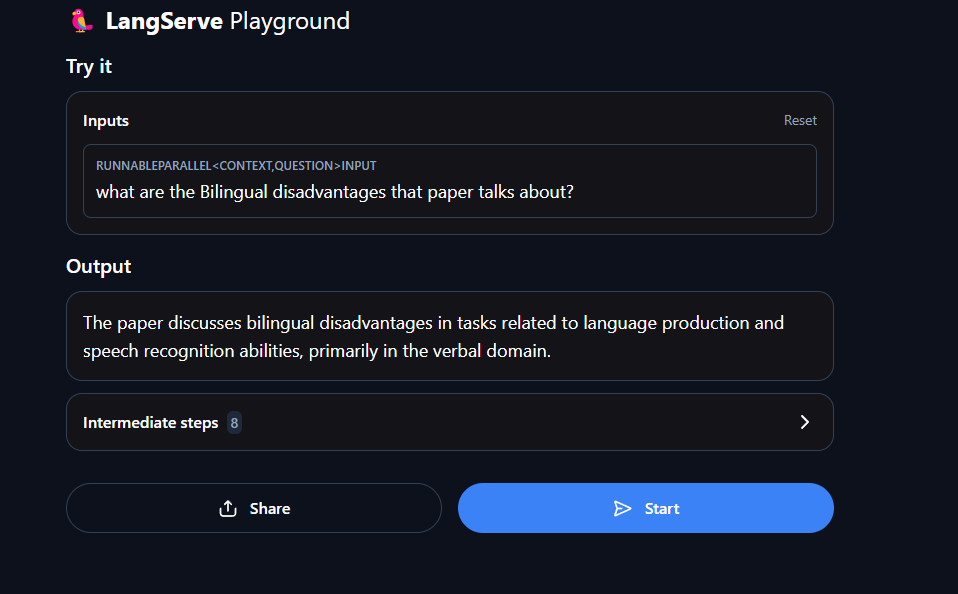

Vuleve a generar la imagen del Docker y hacer el push.

Aquí puedes ver la URL pública: https://langchain-rag-tutorial-jo3ssccpka-no.a.run.app/ 